# Installing and Importing Necessary Dependencies

In [3]:
!pip install -q segmentation-models-pytorch

In [4]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import cv2
from sklearn.model_selection import train_test_split
import albumentations as A
from tqdm import tqdm
import segmentation_models_pytorch as smp

/usr/local/lib/python3.10/dist-packages/albumentations/__init__.py:24: UserWarning: A new version of Albumentations is available: 1.4.23 (you have 1.4.20). Upgrade using: pip install -U albumentations. To disable automatic update checks, set the environment variable NO_ALBUMENTATIONS_UPDATE to 1.
  check_for_updates()


In [27]:
import os
import numpy as np
from torchvision import transforms

In [9]:
if torch.cuda.is_available():
    print("GPU is available!")
    print("GPU Name:", torch.cuda.get_device_name(0))
else:
    print("GPU is not available.")
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

GPU is available!
GPU Name: Tesla T4


In [10]:
def preprocess_image(image_path, input_size=(256, 256)):
    # Load the image
    image = cv2.imread(image_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)  # Convert to RGB

    # Resize the image
    original_size = image.shape[:2]  # Save original size for resizing masks later
    image_resized = cv2.resize(image, input_size)

    # Normalize and convert to tensor
    transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),  # Match ImageNet stats
    ])
    image_tensor = transform(image_resized).unsqueeze(0)  # Add batch dimension
    return image_tensor, original_size, image_resized


# Load Model from Checkpoint

In [11]:
checkpoint_path = "/content/drive/MyDrive/checkpoints/model_epoch_49.pth"
checkpoint = torch.load(checkpoint_path, map_location=device)

<ipython-input-11-cd71d773e9ac>:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(checkpoint_path, map_location=device)


In [12]:
model = smp.Unet(encoder_name="vgg16", encoder_weights="imagenet", in_channels=3, classes=1)
model.load_state_dict(checkpoint['model_state_dict'])
model = model.to(device)
model.eval()

Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/hub/checkpoints/vgg16-397923af.pth
100%|██████████| 528M/528M [00:02<00:00, 239MB/s]


Unet(
  (encoder): VGGEncoder(
    (features): Sequential(
      (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): ReLU(inplace=True)
      (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (3): ReLU(inplace=True)
      (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (6): ReLU(inplace=True)
      (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (8): ReLU(inplace=True)
      (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (11): ReLU(inplace=True)
      (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (13): ReLU(inplace=True)
      (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (15): ReLU(inplace=True)
      

# Inferencing

## Image 1

In [13]:
input_tensor, original_size, resized_image = preprocess_image("/content/inf_images/10378780_15.tiff")


input_tensor = input_tensor.to(device)

In [14]:
with torch.no_grad():
    output = model(input_tensor)

    # Post-process the output
output_mask = output.squeeze(0).cpu().numpy()  # Remove batch dimension and move to CPU
output_mask = (output_mask > 0.5).astype(np.uint8)  # Apply threshold (binary mask)

    # Resize the mask back to the original image size
output_mask_resized = cv2.resize(output_mask[0], (original_size[1], original_size[0]))

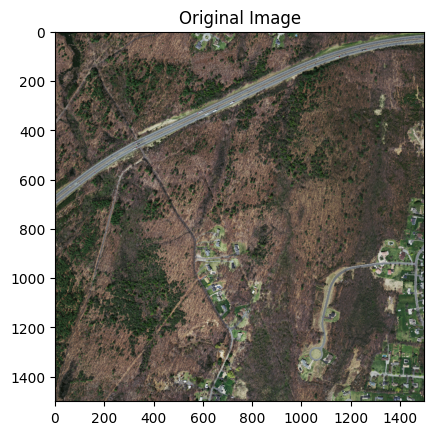

In [17]:
plt.title("Original Image")
plt.imshow(cv2.cvtColor(cv2.imread("/content/inf_images/10378780_15.tiff"), cv2.COLOR_BGR2RGB))

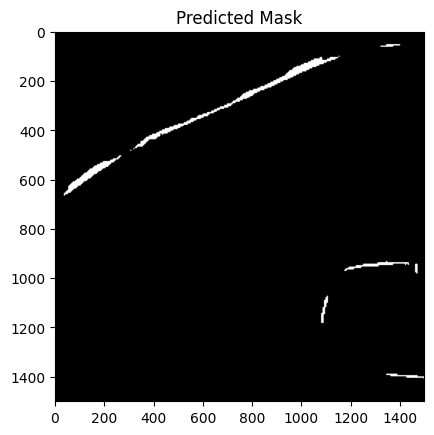

In [18]:
plt.title("Predicted Mask")
plt.imshow(output_mask_resized, cmap="gray")

## Image 2

In [19]:
input_tensor, original_size, resized_image = preprocess_image("/content/inf_images/6759.jpeg")

input_tensor = input_tensor.to(device)

In [20]:
with torch.no_grad():
    output = model(input_tensor)

    # Post-process the output
output_mask = output.squeeze(0).cpu().numpy()  # Remove batch dimension and move to CPU
output_mask = (output_mask > 0.5).astype(np.uint8)  # Apply threshold (binary mask)

    # Resize the mask back to the original image size
output_mask_resized = cv2.resize(output_mask[0], (original_size[1], original_size[0]))


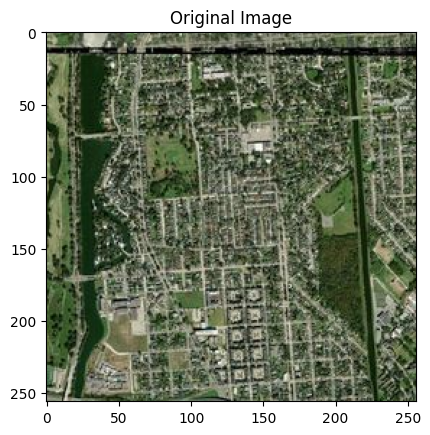

In [21]:
plt.title("Original Image")
plt.imshow(cv2.cvtColor(cv2.imread("/content/inf_images/6759.jpeg"), cv2.COLOR_BGR2RGB))

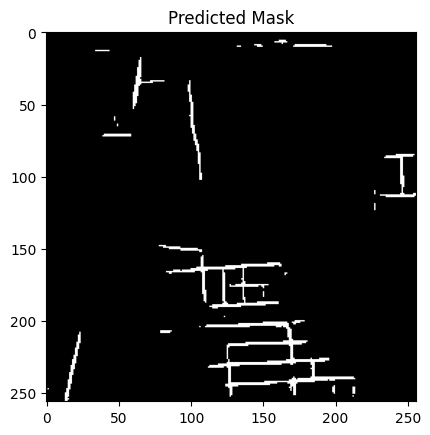

In [22]:
plt.title("Predicted Mask")
plt.imshow(output_mask_resized, cmap="gray")

## Image 3

In [23]:
input_tensor, original_size, resized_image = preprocess_image("/content/inf_images/Flight_01_00032.JPG")


input_tensor = input_tensor.to(device)

In [24]:
with torch.no_grad():
    output = model(input_tensor)

# Post-process the output
output_mask = output.squeeze(0).cpu().numpy()  # Remove batch dimension and move to CPU
output_mask = (output_mask > 0.5).astype(np.uint8)  # Apply threshold (binary mask)

# Resize the mask back to the original image size
output_mask_resized = cv2.resize(output_mask[0], (original_size[1], original_size[0]))


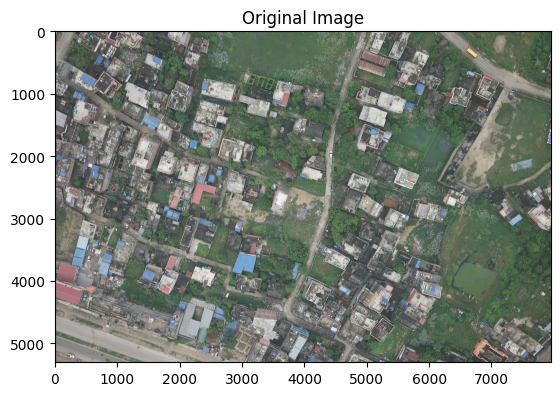

In [25]:
plt.title("Original Image")
plt.imshow(cv2.cvtColor(cv2.imread("/content/inf_images/Flight_01_00032.JPG"), cv2.COLOR_BGR2RGB))

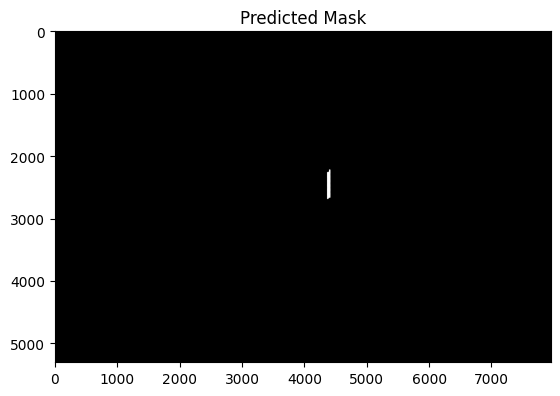

In [26]:
plt.title("Predicted Mask")
plt.imshow(output_mask_resized, cmap="gray")